### Problem Statement 

Development of an Adaptable Deep Learning Model for Artistic Style Transfer

#### Introduction:
- Neural Style Transfer is an artistic technique that combines the content of one image with the style of another.
- The goal of this assignment is to implement Neural Style Transfer using TensorFlow and Keras.

##### Analysing the problem statement

- Conduct proper research about what is Neural Style Transfer 
- How it is used to generate Artistic Style Transfer ?
- What is content loss and style loss and how to optimise these ?
- Refering to the base paper - https://arxiv.org/abs/1508.06576

##### Analysis the structure of VGG19 used for Neural Style Transfer 

- Which layer is used to extract the style ?
- Which layer is used to extract the content ?
- Analysing several hyperparameters and their effect

Simple VGG19

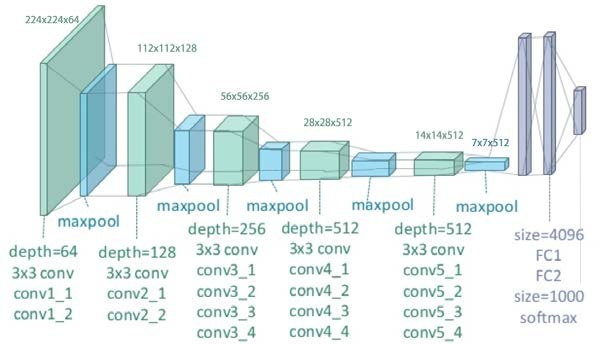

Small correction - the VGG19 we are using is with averge pooling 

#### Setup and Dependencies:
- Install the necessary libraries and dependencies:
  ```bash
  pip install tensorflow matplotlib Pillow

In [74]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np
import PIL.Image 

#### Data Preprocessing:
- Load and preprocess the content and style images using the provided preprocess_image function.
- Display the content and style images using the imshow function.

In [75]:
# Funtion to comvert tensor to image 
def tensor_to_image(tensor):
  tensor = tensor*255 # tensor scaling 
  tensor = np.array(tensor, dtype=np.uint8) # converting to numpy array
  # if tensor have more than 3 dimension it is assumed to have a batch of images 
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [76]:
# converting an image to a 4D tensor --> (batch size + image)
def preprocess_image(path):
    # resizing
    max_dim = 512
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    
    # normalize between [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    
    long_dim = max(shape)
    
    # aspect ratio
    scale = max_dim / long_dim

    # Resizing using aspect ratio
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    # adding a batch dimension
    img = img[tf.newaxis, :]
    return img


In [77]:
# display the image 
def imshow(image, title):
    # 4D tensor | 0th dimesion --> batch --> remove
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    plt.title(title)

#### Model Architecture:
- Define the architecture of the StyleContentModel class:
- Utilizes VGG19 layers for feature extraction.
- Calculates Gram matrices for style representation.
- Implements the style and content loss functions.

In [78]:
# calculating gram matrix --> correlation matrix of feature maps 
def gram_matrix(input_tensor):
    # Flatten the spatial dimensions of the tensor
    # change order (batch_size, height, width, channels) --> (width, batch_size, height, channels)
    if input_tensor.shape.ndims == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)
    permuted_tensor = tf.keras.backend.permute_dimensions(input_tensor, (0, 2, 1, 3))
    flat_tensor = tf.keras.backend.batch_flatten(permuted_tensor)

    # Calculate the dot product of the features maps to find the correlation matrix of feature maps 
    gram_matrix = tf.keras.backend.dot(flat_tensor, tf.keras.backend.transpose(flat_tensor))

    return gram_matrix


In [79]:
# defining a model 
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', pooling= 'avg')
    vgg.trainable = False # setting weights as non - trainable 

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [80]:
# defines a neural network model
# The purpose of this model is to extract style and content features from an input image.

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [81]:
#  loss function
def style_content_loss(outputs, style_weight, content_weight, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_style_layers = len(style_targets)
    num_content_layers = len(content_targets)

    # calculaing style loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    # calculating content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#### Training:
- Initialize the model, set hyperparameters, and create an optimizer.
- Extract style and content features from target images.
- Train the model using the train_step function and visualize the progress.

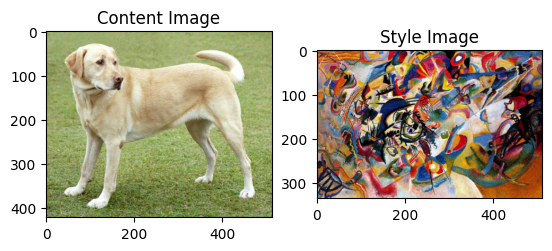

In [82]:
content_path = "I1.jpg"
style_path = "s1.jpeg"

content_image = preprocess_image(content_path)
style_image = preprocess_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# taking a deep conv layer as it has more features 
content_layers = ['block5_conv2'] 

# take first layer of every block  
# we can take other combination in accordance of research paper - https://arxiv.org/abs/1508.06576
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

extractor = StyleContentModel(style_layers, content_layers)

# getting target tensors 
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# noisy image
image = tf.Variable(content_image)

# optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [83]:
# ensure that the value of pixel is between 0 - 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [84]:
# Minimizing loss
@tf.function()
def train_step(image, extractor, opt, style_weight, content_weight, style_targets, content_targets):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_weight, content_weight, style_targets, content_targets)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

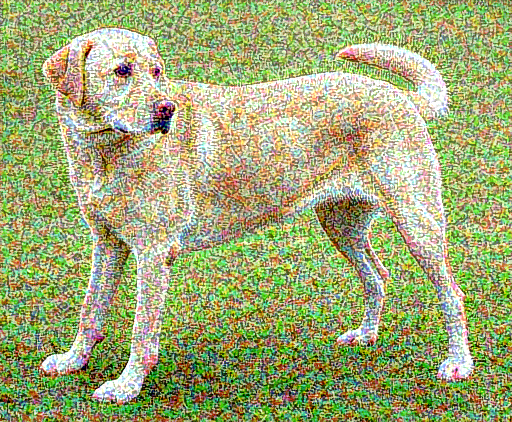

In [85]:
epochs = 30

for n in range(epochs):
    train_step(image, extractor, opt, style_weight, content_weight, style_targets, content_targets)

tensor_to_image(image)    

##### Limitations 

- Hyperparameters such as style_weight, content_weight, and learning_rate are fixed. Optimizing these hyperparameters based on the specific characteristics of input images might improve the quality of the stylized output.
- It takes a lot of iterations and time for giving a perfect output --> need to be improved